## Quantum State Tomography (QST) using Quantum Machine Learning (QML) 

### Introduction:  
In this notebook we reproduce the results from the paper (http://export.arxiv.org/pdf/1912.07286): Variational Quantum Circuits for Quantum State Tomography (liu et al, 2020). 

The paper introduces a hybrid classical-quantum framework for performing quantum state tomography. The scheme begins with a randomized target state $\psi$, it uses a variational quantum circuit to generate an estimate state $\phi$. The fidelity between states can be computed via the swap test (as referenced in the paper). A loss function is proposed which implicitly maximizes the fidelity between $\phi$ and $\psi$. This loss function is used to tune the parameters of the variational quantum circuit. Once the optimal parameters have been determined, one simply needs to use a classical simulator to simulate the quantum state associated with that particular variational circuit. 

Here we provide an implementation of this scheme and produce results comparable to the original paper.

In [1]:
import qml_main
import qpu
import copt
import numpy as np
import matplotlib.pyplot as plt

### Loss vs Iterations: 
In this section we initialize our target state $\psi$ (5 qbit state) and train our variational quantum circuit (VQC) using the ansatz described in the paper. One of the hyper parameters of this ansatz is its 'depth', we use a 'depht' value of 10. We plot the loss as a function of the number of iterations. A similar figure is provided in the paper (figure 1b).  

In [3]:
psi = qml_main.generate_random_psi(num_qbits=5)                        # randomly select a target state |psi> 
initial_theta = qml_main.initialize_theta(circ_depth=10, num_qbits=5)  # initialize the parameters of our variational circuit

results, optimizer_data = copt.optimize_theta_scp(initial_theta, psi)  # Final result 

print("Done, final loss: {}".format(results.fun))

Done, final loss: 0.014167171196032724


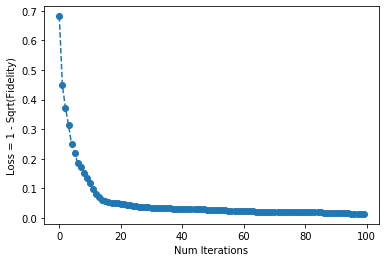

In [4]:
# Plot results

loss_data = []
fidelity_data = []

for theta_vect in optimizer_data:
    theta = np.reshape(theta_vect, (10, 5)) 
    fidelity = copt.get_fidelity(theta, psi)
    loss = copt.get_loss(fidelity)
    
    loss_data.append(loss)
    fidelity_data.append(fidelity)

optimized_theta = np.reshape(optimizer_data[-1], (10, 5))
phi = qpu.get_state(optimized_theta)    
    
plt.plot(range(len(loss_data)), loss_data, label='loss', marker='o', linestyle='--')
plt.xlabel('Num Iterations')
plt.ylabel('Loss = 1 - Sqrt(Fidelity)')
plt.show()

### Fidelity vs Depth: 
In this section we train multiple VQCs while varying the depth parameter. The depth of the VQC is directly proportional to the run time of the algorithm; thus it is valuable to analyze the effect of depth on accuracy (i.e how small can the depth be without comprimizing accuracy?) We plot 1 - fidelity as a function of the depth (on a logirithmic scale). A similar figure is provided in the paper (figure 1a). 

In [5]:
depth_lst = range(1, 21)
loss_lst = []
one_minus_fidelity_lst = []

for depth in depth_lst:
    print('Processing depth: {}/{}'.format(depth, 20))
    initial_theta = qml_main.initialize_theta(circ_depth=depth, num_qbits=5)
    results, optimizer_data = copt.optimize_theta_scp(initial_theta, psi)
    
    theta = np.reshape(optimizer_data[-1], (depth, 5)) 
    fidelity = copt.get_fidelity(theta, psi)
    loss = copt.get_loss(fidelity)
    
    loss_lst.append(loss)
    one_minus_fidelity_lst.append(1 - fidelity)


Processing depth: 1/20
Processing depth: 2/20
Processing depth: 3/20
Processing depth: 4/20
Processing depth: 5/20
Processing depth: 6/20
Processing depth: 7/20
Processing depth: 8/20
Processing depth: 9/20
Processing depth: 10/20
Processing depth: 11/20
Processing depth: 12/20
Processing depth: 13/20
Processing depth: 14/20
Processing depth: 15/20
Processing depth: 16/20
Processing depth: 17/20
Processing depth: 18/20
Processing depth: 19/20
Processing depth: 20/20


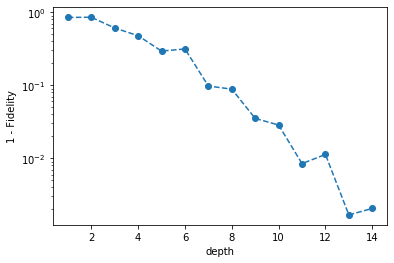

In [11]:
# Plot results

plt.plot(depth_lst[:14], one_minus_fidelity_lst[:14], marker='o', linestyle='--')  # between 15-20 depth we are over training 
plt.xlabel('Depth')                                                                # the model so I think its safe to exclude
plt.ylabel('1 - Fidelity')
plt.yscale('log')
plt.show()   